# Structural Damage Assesment for Windstorm Events

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [STORMS](https://github.com/CLIMAAX/STORMS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

:::{important} Objectives
Assessing the structural damage on buildings for a storm event.
- Obtain 50mx50m European land use raster data 
- Explore wind vulnerability curves for buildings
- Create new vulnerability curves to fit the land use data
- Match the data sets so they can be used for damage calculation
- Absolute and relative damage calculation!
:. 

## Risk assessment methodology

This event-based windstorm risk workflow can be used to estimate the damages caused by a storm by combining hazard, exposure and vulnerability. The workflow is a simplified version of the work by [Koks & Haer (2020)](https://doi.org/10.1038/s41598-020-63580-w). Here the hazard is represented by a map with the maximum 3-second wind gust of a storm event. Exposure is determined by a map in which assets are associated with maximum damage that can occur per square meter of the asset and a certain exposure class is given to the asset. Vulnerability is defined as a collection of damage curves where the 3 second wind gusts are matched to a percentage of the asset that is damaged.

 By combining all datasets, it is possible to assign to each asset the following information:
 - the type of asset (asset class)
 - the maximum damage of the asset (in economic terms)
 - the vulnerability curve of the asset (wind gust vs. relative damage)
 - the windspeed at the asset location during the storm. 
 
 With this information, one can do the damage calculation per asset. Based on the wind gust speed during the storm, the vulnerability curve is applied to determine to what extent is the asset damaged by this wind speed. Multiplying the maximum cost of the damage to this asset by the damage percentage results in the estimated damage by the storm to that asset. Performing this calculation for all asset locations in the region results in a damage map, that helps to determine locations that are most affected (have the highest costs of the damages).

### Hazard data

The hazard is represented by the storm footprint, a map with the maximum 3-second wind gust of a storm.
The Copernicus Climate Data Store offers a dataset of historical [windstorm footprints derived from reanalysis over Europe](https://doi.org/10.24381/bf1f06a9).

### Exposure data
An example dataset that can be used in this workflow is the [LUISA Land Cover data](https://data.jrc.ec.europa.eu/dataset/51858b51-8f27-4006-bf82-53eba35a142c).  With this dataset, the exposed asset is a 50x50m grid cell. Each land cover type is given a certain asset class that can be associated with the vulnerability curves. 

Each land cover type is also associated with a maximum damage per square meter. A first estimation of the maximum damages are based on [JRC maximum damage estimates](https://dx.doi.org/10.2760/16510) per country.

### Vulnerability data  
Each asset class is associated with a vulnerability curve. The vulnerability data consists of six curves determined by [Feuerstein et al. (2011)](https://doi.org/10.1016/j.atmosres.2010.12.026). The asset classes are differentiated by the type of building that are mainly present in the asset. These estimate damage curves can be found in the supplied material. 


## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [1]:
## name the area for saving datasets and plots# specify the coordinates of the bounding box
bbox = [-8.811,42.6647,-7.1524,43.8009] # North-West Spain
areaname = 'DeLugo_Spain'
storm_name = 'Klaus'

# Examples:
# bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle'
#bbox = [1.983871,41.252461,2.270614,41.449569]; areaname = 'Barcelona'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'
#bbox = [-9.250441,38.354403,-8.618666,38.604761]; areaname = 'Setubal'

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [zipfile](https://docs.python.org/3/library/zipfile.html#zipfile-objects) - To download and unzip the data
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - To calculate the damage maps
- [matplotlib](https://matplotlib.org/) - To plot results
- [numpy](https://numpy.org/) & [pandas](https://pandas.pydata.org/) - To work with and manipulate data
- [contextily](https://contextily.readthedocs.io/en/latest/index.html#) - To plot maps with topographical context  


These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [2]:
import os

import pooch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rioxarray as rxr
from rasterio.enums import Resampling
from damagescanner.core import RasterScanner
import contextily as ctx

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.

The next cell will create the directory called `STORM_event_raster` in the same directory where this notebook is saved.

In [3]:
# Define the folder for the storm workflow
workflow_folder = 'STORM_event_raster'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
if not os.path.exists(general_data_folder):
    os.makedirs(general_data_folder)

In [4]:
# Define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Collect, Download and Explore data

In this part, we will ensure we have all the files we need to complete this workflow.

### Hazard data

First we load in the data obtained in the [hazard assessment](Hazard_assessment_STORMS.ipynb). Make sure to do that step first. Otherwise there is no hazard data to do the calculations with.

In [5]:
# open the netcdf file saved
windstorm_region = rxr.open_rasterio(f'{data_dir}/{storm_name}.nc')

# only keep values that are not nan
windstorm_region = windstorm_region.where(windstorm_region > 0)

Text(0.5, 1.0, 'Windstorm Klaus across the region')

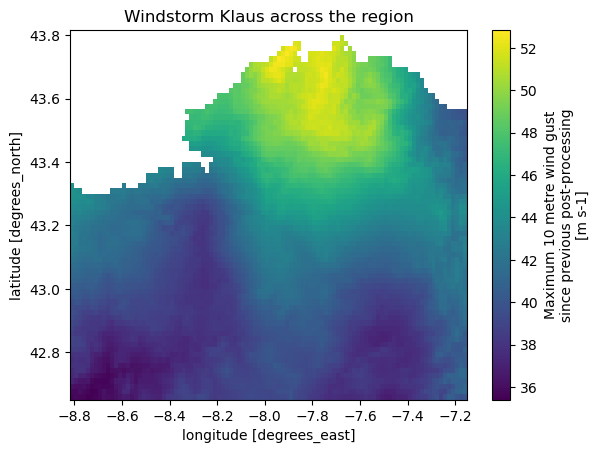

In [6]:
windstorm_region.plot()

#set title
plt.title(f'Windstorm {storm_name} across the region')

### Exposure data

In this worflow we use the [LUISA land cover dataset](http://data.europa.eu/89h/51858b51-8f27-4006-bf82-53eba35a142c).

The code in the next cell downloads the file automatically from within this notebook or you can download the file manually into the `STORMS_event_raster/general_data` folder by clicking [here](http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/LandUse/2018/LATEST/LUISA_basemap_020321_50m.tif) (size approx. 1 GB).

In [7]:
filename_land_use = pooch.retrieve(
    url="https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/LandUse/2018/LATEST/LUISA_basemap_020321_50m.tif",
    known_hash=None,
    fname="LUISA_basemap_020321_50m.tif",
    path=general_data_folder
)

Next we analyse the exposure data. There are datasets to analyse. First, the downloaded landcover data and then the maximum damage per landcover class.

#### Land cover data

Using rioxarray, the lancover data is opened and the correct band is selected. In this case the band of interest is 1 (also the only band). Also for this dataset the crs needs to be written. From there we want to visualise the land cover map, however, since the land cover data has a detailed resolution (100m by 100m) it takes a long time to plot all of Europe. That is why we clip the land use to the region of our bounding box before plotting. To match the colours on the LUISA Land Cover data portal we define a set of colours to plot the data with.

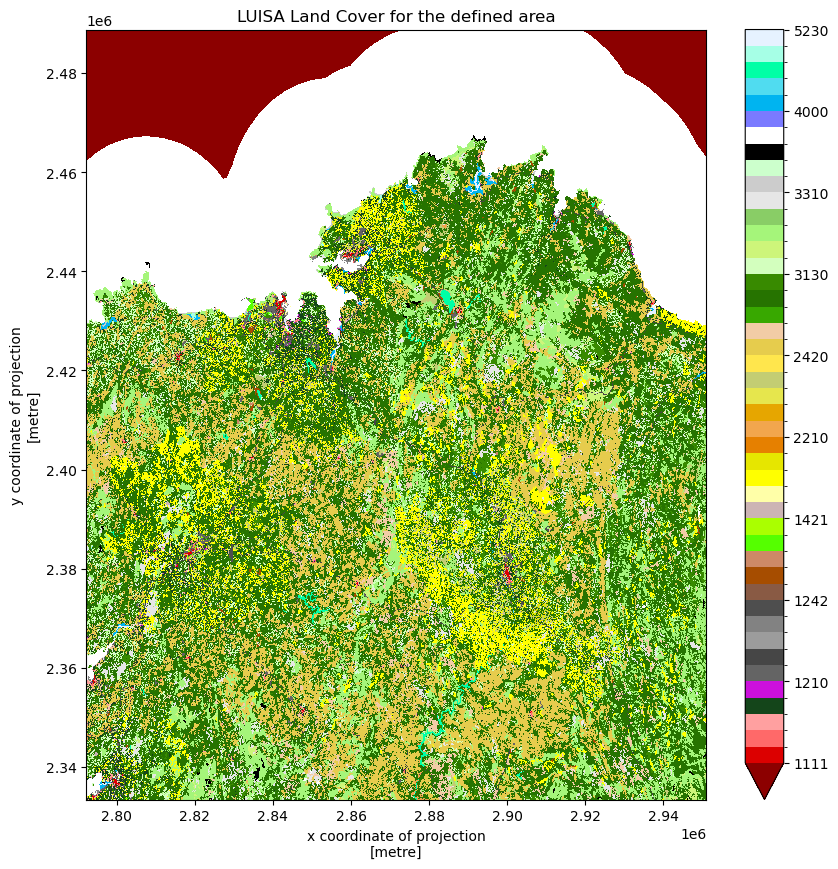

In [8]:
filename_land_use = f'{general_data_folder}/LUISA_basemap_020321_50m.tif'
land_use = rxr.open_rasterio(filename_land_use)
land_use = land_use['band'==1]
land_use = land_use.drop_vars(['band'])
land_use.rio.write_crs(3035, inplace=True)

land_use_test_plot = land_use.rio.clip_box(*bbox, crs="EPSG:4326")

LUISA_values = [1111,1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]


# plot the land use
land_use_test_plot.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10,10))
plt.title('LUISA Land Cover for the defined area')

# we delete the map variable to save computing resources for later
del land_use_test_plot

#### Maximum damage per land cover class

Next, we extract the maximum structural damage that can occur per land use class  [€/m²] from the larger `LUISA_damage_info_curves.xlsx` sheet and save it to something we can use later. We only show the first 10 values, just to get an idea of what is in there. We see that there is quite a bit of variation in the type of landuse and the value that it has.


:::{tip}

Please go into the file `LUISA_damage_info_curves.xlsx` and adjust the GDP of the country for which the calculation is done to calculate more realistic economic damage estimates.
See the Handbook page on [maximum damage estimation](https://handbook.climaax.eu/resources/FAQ/maximum_damages.html) for more information about the spreadsheet and calculations.
:::

In [9]:
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)
# get the maxdamage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['structural €/m²'])
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')
maxdam.head(10)

,structural €/m²
Land use code,
1111,343.011305
1121,243.823177
1122,140.013142
1123,36.799571
1130,0.000000
1210,180.105953
1221,16.166945
1222,226.337232
1230,97.001671


### Exposure

Since the land use data is also for the whole of Europe we clip our region to our defined bounding box too. However, we keep the land use file in its original CRS

In [10]:
# clip land use to the same extent as the windstorm
land_use_region = land_use.rio.clip_box(*bbox, crs="EPSG:4326")

# Only keep values higher than 0 (no data)
land_use_region = land_use_region.where(land_use_region > 0)

# we delete the map variable to save computing resources for later
del land_use

Now that we have our region of interst for the land cover. It is also interesting to see the damage potential in the region due to high wind speeds. We see that most valuable assests are located in the cities.

Text(0.5, 1.0, 'Damage potential of structures in the region based on land use and max. damage values')

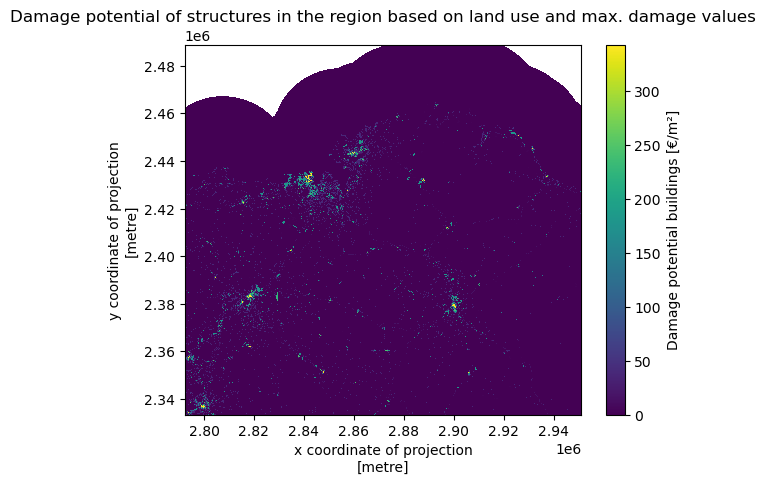

In [11]:
# assign each land use class a maxdamage value and plot this on the map
maxdam_map = land_use_region
for class_i in maxdam.index:
    maxdam_map = maxdam_map.where(land_use_region != class_i, maxdam['structural €/m²'][class_i])
maxdam_map.plot(cbar_kwargs={'label': "Damage potential buildings [€/m²]"})
plt.title('Damage potential of structures in the region based on land use and max. damage values')

### Vulnerability data
For this workflow initial information for the creation of maximum damages and damage curves are provided in `LUISA_damage_info_curves.xlsx` and `CURVES_feuerstein_koks.csv`.
However, these are just estimates and need to be adjusted according to the regional context to provide valid damage estimations.
See the Handbook page on [vulnerability curves](https://handbook.climaax.eu/resources/FAQ/vulnerability_curves.html) for more information and feel free to adjust manually.

Finally, we inspect the vulnerability curves that we will use in the analysis. In the index we see that there is the windspeed associated with a construction class and a fraction of the building of a specific class that is destroyed at that wind speed. The end of the table is shown to represent fraction of the building that is damaged at high wind speeds.

In [12]:
curves_feuerstein = pd.read_csv(f'CURVES_feuerstein_koks.csv', index_col=0)
curves_feuerstein.tail()

,weakest outbuilding,outbuilding strong,outbuilding,weak brick structure,strong brick structure,concrete buidling
wind speed,,,,,,
136,100.0,100.0,100.0,100.0,99.50,85.5
137,100.0,100.0,100.0,100.0,99.70,86.1
138,100.0,100.0,100.0,100.0,99.90,86.5
139,100.0,100.0,100.0,100.0,99.99,86.8
140,100.0,100.0,100.0,100.0,100.00,87.0


Plotting the curves makes the damage functions more insightful. Steep curves indicate a quick change in damage with only a small change in wind speed. Flat curves indicate a small change in damage with a large change in wind speed and are therefore more resilient to high windspeeds.

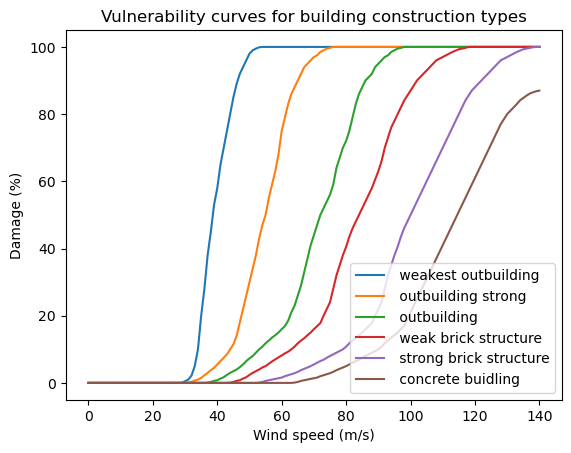

In [13]:
curves_feuerstein.plot()
plt.title('Vulnerability curves for building construction types')
plt.ylabel('Damage (%)')
plt.xlabel('Wind speed (m/s)')

# only show legend for the first 10 entries
plt.legend(curves_feuerstein.columns[:10], loc='lower right')

## Process the data

In this section we will first process the data before we do our damage calculations. This is needed since the windspeed map and land cover map have different resolutions and projections meaning they do not match when we overlay them directly. Also the vulnerability curves need to be adjusted to fit with the types of buildings in the land use class.

## Vulnerability

Here we will adjust the damage curves of Feuerstein et al. (2011) to fit our LUISA land use map. From the Luisa info excel sheet we can retrieve a ratio of the type of buildings per land use class. If a land use class contains a lot of one certain construction type the vulnerability curve will be close of the one represented by Feuerstein et al. (2011). Otherwise it will be a curve that is a mix of the building construction types according to the ratio of structures in the land use. We see a large variation in vulnerability curves and also some curves that are flat at 0. These indicate that the land use class is not affected by wind, e.g., water bodies.

In [14]:
# create a new dataframe for damage_curves_luisa where wind and landuse classes are used
damage_curves_luisa = curves_feuerstein.copy()
# drop all columns
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

building_types = ['weakest outbuilding', 'outbuilding',	'strong outbuilding', 'weak brick structure',	'strong brick structure', 'concrete buidling']

# for each land use class in maxdamage create a new damage curve
for landuse in maxdam.index:
    # find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # new curve
    damage_curves_luisa[landuse] =  ratio[0] * curves_feuerstein.iloc[:,0] + \
                                    ratio[1] * curves_feuerstein.iloc[:,1] + \
                                    ratio[2] * curves_feuerstein.iloc[:,2] + \
                                    ratio[3] * curves_feuerstein.iloc[:,3] + \
                                    ratio[4] * curves_feuerstein.iloc[:,4] + \
                                    ratio[5] * curves_feuerstein.iloc[:,5]

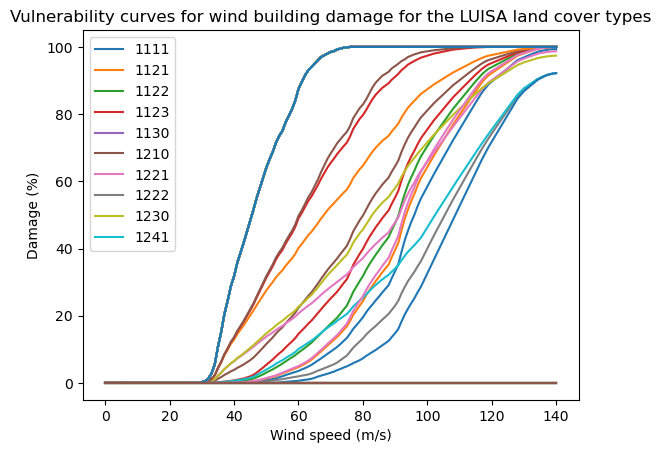

In [15]:
damage_curves_luisa.plot()
plt.title('Vulnerability curves for wind building damage for the LUISA land cover types')
plt.ylabel('Damage (%)')
plt.xlabel('Wind speed (m/s)')

# only show legend for the first 10 entries
plt.legend(damage_curves_luisa.columns[0:10], loc='upper left')

In [16]:
# Adjust value range of damage curves before writing: RasterScanner function used below
# expects values in range [0, 1] (percent as fraction) but imported curves are defined
# in range [0, 100] (percent)
damage_curves_luisa = 0.01 * damage_curves_luisa

damage_curves_luisa.to_csv(os.path.join(data_dir, 'damage_curves_luisa.csv'))

### Matching layers

Now that the two datasets are in the same region, we can increase the resolution of the wind map and reproject the wind map to match that of the land cover map. When increasing the resolution we need to do something with the added datapoints in our map. We can either fill these new datapoints in with whatever valaue is nearest in the orignal data set or we can interpolate the data. Choose something that makes sense. For wind data it is more logical to interpolate since abrupt changes along an arbitrary line of pixels is unlikely. However, for land use data it might make sense to choose the nearest datapoint. Otherwise the interpolation method will create new land use classes, which will be void of meaning. For example, on the edge between land use class 10 and 11 it will create 10.5 or between class 1 and 10 it will set pixels to 5 without the pixel actually being class 5.

Text(0.5, 1.0, 'Windstorm data matched to land use data')

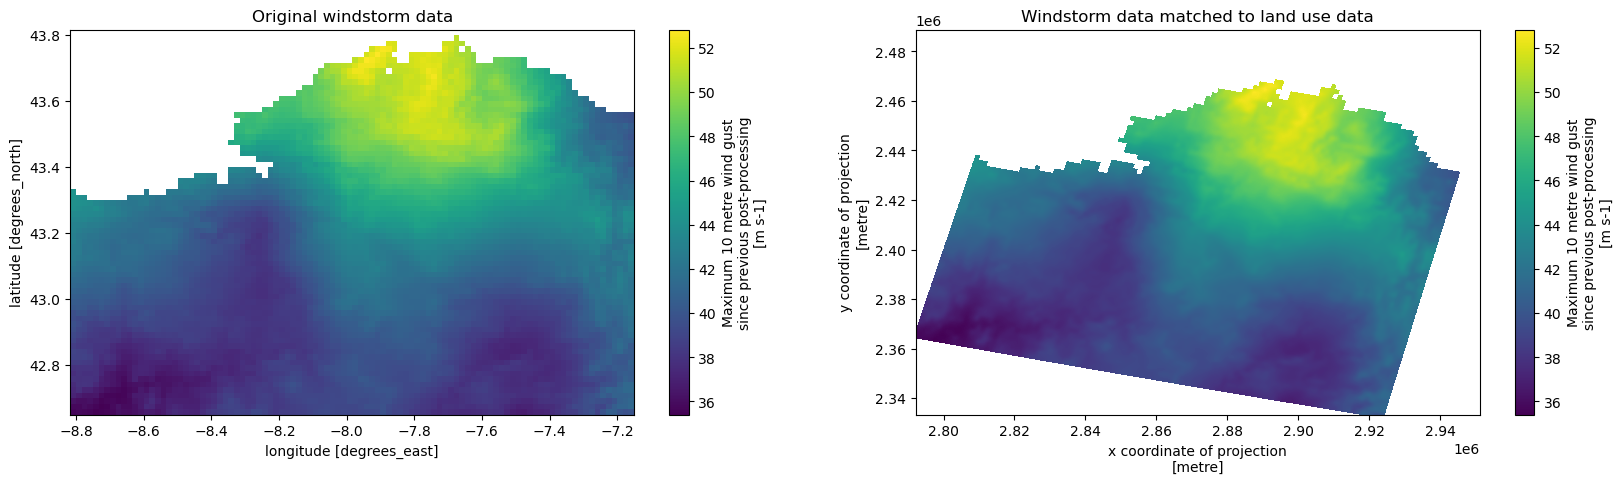

In [17]:
windstorm_region_matched = windstorm_region.rio.reproject_match(land_use_region, resampling = Resampling.cubic) # can also be .nearest or

windstorm_region_matched = windstorm_region_matched.assign_coords({
    "x": land_use_region.x,
    "y": land_use_region.y,
})

# remove nan values
windstorm_region_matched = windstorm_region_matched.where(windstorm_region_matched > 0)[0]

# plot windstorm_region and windstorm_region_matched next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

windstorm_region.plot(ax=ax1)
ax1.set_title("Original windstorm data")

windstorm_region_matched.plot(ax=ax2)
ax2.set_title("Windstorm data matched to land use data")

# we delete the map variable to save computing resources for later
# del windstorm_region

We find two things. Firstly, the map is skewed due to our reprojection and secondly the map is smoother than the original dataset due to our Resampling method.

Now we can overlay the two images to get a quick look at where high windspeeds are and where certain land cover classes are. We see that there is some mismatch between the maps due to our reprojection. When the damage estimates are calculated only values are calculated for the locations where both maps overlap

Text(0.5, 1.0, 'Windstorm and land use 2018')

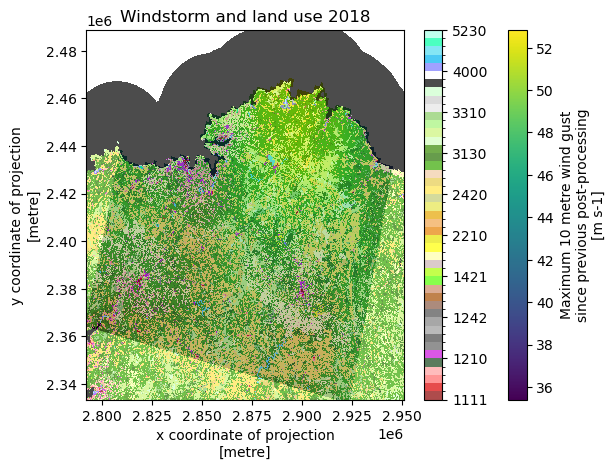

In [18]:
fig, ax = plt.subplots()
windstorm_region_matched.plot(ax=ax, cmap='viridis', alpha=1)
land_use_region.plot(ax=ax, levels=LUISA_values, colors=LUISA_colors, alpha=0.7)
ax.set_title('Windstorm and land use 2018')

:::{note}

Because the used DamageScanner package uses the resolution of the maps to calculate the area in m² it is important that both maps are in a CRS that uses meters instead of degrees.
:::

In [19]:
# set the correct order of the coordinates in the data set
windstorm_region_matched.transpose('y', 'x')
land_use_region=land_use_region.transpose('y', 'x')

Now we save the raster maps of the windstorm and land use to .tif files so these can be used in the damage calculation

In [20]:
windstorm_region_matched.rio.to_raster(f'{data_dir}/windstorm_region_matched.tif')
land_use_region.rio.to_raster(f'{data_dir}/land_use_region.tif')

## Calculate structural damage

Now that we have everything ready, we can do the damage calculation using the RasterScanner function from the DamageScanner python package. Making the 

In [21]:
# code for the calculation
wind_map = os.path.join(data_dir,'windstorm_region_matched.tif')
landuse_map = os.path.join(data_dir,'land_use_region.tif')

curve_path = os.path.join(f'{data_dir}/damage_curves_luisa.csv')
maxdam_path = os.path.join(f'{data_dir}/maxdam_luisa.csv')

damage_category, _, _, _ = RasterScanner(
    landuse_file=landuse_map,
    hazard_file=wind_map,
    curve_path=curve_path,
    maxdam_path=maxdam_path,
    output_path=data_dir,
    scenario_name=f'windstorm_{storm_name}_{areaname}',
    lu_crs=land_use_region.rio.crs,
    haz_crs=windstorm_region_matched.rio.crs,
    dtype=np.int64,  # int32 default gives an error
    save=True
)

## Plot the results

From the results we can obtain the total damages in the area per land cover class. We first check the summed damage for each land use class. Land cover classes can obtain high damages because they are either valuable per m² or a lot of area in the region is of a certain land cover. For example, large but not as valuable land can still have a higher damage total than small but very valuable land.  

In [22]:
LUISA_legend = LUISA_info_damage_curve['Description']
loss_df_all_mln = damage_category * 1e-6

category_damage = pd.concat([LUISA_legend, (loss_df_all_mln)], axis=1)
category_damage.sort_values(by='damages',ascending=False, inplace=True)

# rename 'damages' to 'Damages [mln €]'
category_damage.rename(columns={'damages': 'Damages [mln €]'}, inplace=True)

category_damage

,Description,Damages [mln €]
1210,Industrial or commercial units,906.899945
2420,Complex cultivation patterns,671.500147
3220,Moors and heathland,388.527864
2110,Non irrigated arable land,332.268827
1123,Isolated or very low density urban fabric,218.027362
1330,Construction sites,148.571220
3240,Transitional woodland shrub,116.524695
1221,Road and rail networks and associated land,115.327886
2310,Pastures,80.234797
2430,Land principally occupied by agriculture,70.884143


In [23]:
# we calculate the total damage in the region of the event in millions of euros
print(f"Total damages in the region [mln. €]: { damage_category.sum().values[0] * 1e-6}")

Total damages in the region [mln. €]: 3253.3471769999996


Now we will plot the damages on a map to gain more insight where the storm caused most damage. First we plot pure economic value that is affected and then we asses which locations are relatively hit the hardest by a windstorm by representing the manifested structural damage versus the maximum structural damage.

In [24]:
# import the saved damagemap into python
damage_map = rxr.open_rasterio(os.path.join(data_dir, f'windstorm_{storm_name}_{areaname}_damagemap.tif'))

In [25]:
# Currently the damages are represented in total damage of a grid cell so we change it to represent damage per m2
damage_map_adjusted = damage_map / (abs(damage_map.rio.resolution()[0] * damage_map.rio.resolution()[1]))

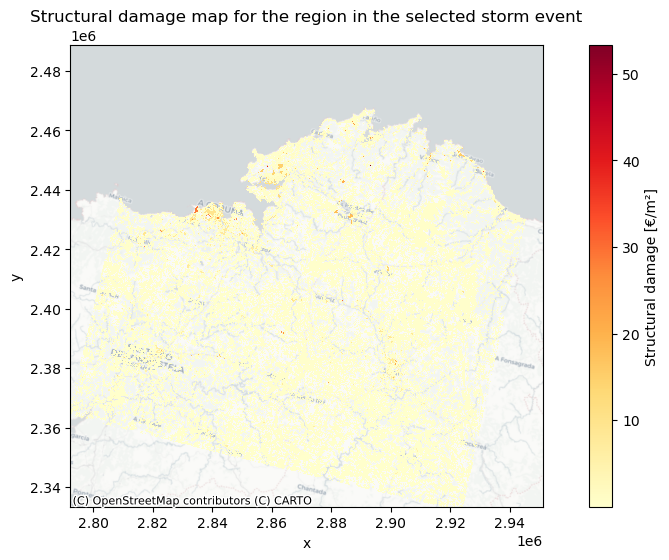

In [26]:
# create figure
fig, ax = plt.subplots(figsize=(12, 6))

damage_map_adjusted = damage_map_adjusted.where(damage_map_adjusted > 0)

damage_map_adjusted.plot(ax=ax, cmap='YlOrRd', cbar_kwargs={'label': "Structural damage [€/m²]"})
plt.title('Structural damage map for the region in the selected storm event')

# add basemap from openstreetmap
ctx.add_basemap(ax, crs=damage_map_adjusted.rio.crs.to_string(), alpha=1, source=ctx.providers.CartoDB.Positron)

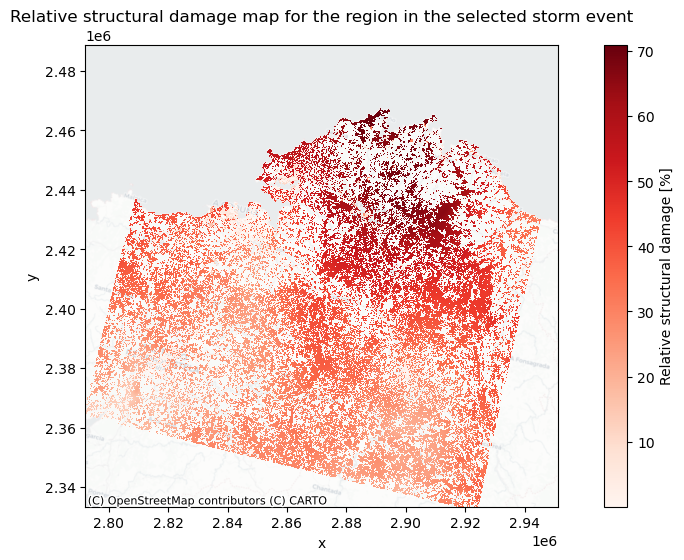

In [27]:
# plot the relative damage for each land use class
fig, ax = plt.subplots(figsize=(12, 6))
# set figure size

relative_damage = (damage_map_adjusted / maxdam_map) * 100

# filter out assests that do not have a damage potential
relative_damage = relative_damage.where(relative_damage > 0)

relative_damage.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Relative structural damage [%]"})

plt.title('Relative structural damage map for the region in the selected storm event')

# add basemap from openstreetmap
ctx.add_basemap(ax, crs=relative_damage.rio.crs.to_string(), alpha=0.5, source=ctx.providers.CartoDB.Positron)

## Conclusions

In this risk assessment workflow we learned how to match event and land cover maps so they can be put into the damagescanner function. We then visualised the damage estimation for a storm using pure economic damage and then using relative structural damage.  

## Contributors

- Ted Buskop (Deltares & Vrije Universiteit Amsterdam, IVM)


## References

- Koks, E.E., Haer., T. A high-resolution wind damage model for Europe. Sci Rep 10, 6866 (2020). https://doi.org/10.1038/s41598-020-63580-w
- Copernicus Climate Change Service (2025): Windstorm tracks and footprints derived from reanalysis over Europe between 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: [10.24381/bf1f06a9](https://doi.org/10.24381/bf1f06a9)
- Feuerstein, B., Groenemeijer, P., Dirksen, E., Hubrig, M., Holzer, A. M., & Dotzek, N. (2011). Towards an improved wind speed scale and damage description adapted for Central Europe. Atmospheric Research, 100(4), 547-564. https://doi.org/10.1016/j.atmosres.2010.12.026
- Pigaiani, C. and Batista E Silva, F., The LUISA Base Map 2018, EUR 30663 EN, Publications Office of the European Union, Luxembourg, 2021, ISBN 978-92-76-34207-6,  https://doi.org/10.2760/503006, JRC124621.